In [1]:
import or_suite
import numpy as np

import copy

import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd


import gym

# OR Suite 

##  Ambulance Routing Environment

One potential application of reinforcement learning involves positioning a server or servers (in this case an ambulance) in an optimal way geographically to respond to incoming calls while minimizing the distance traveled by the servers. 

This is closely related to the [k-server problem](https://en.wikipedia.org/wiki/K-server_problem), where there are $k$ servers stationed in a space that must respond to requests arriving in that space in such a way as to minimize the total distance traveled. 

The ambulance routing problem addresses the problem by modeling an environment where there are ambulances stationed at locations, and calls come in that one of the ambulances must be sent to respond to. The goal of the agent is to minimize both the distance traveled by the ambulances between calls and the distance traveled to respond to a call by optimally choosing the locations to station the ambulances. The ambulance environment has been implemented in two different ways; as a 1-dimensional number line $[0,1]$ along which ambulances will be stationed and calls will arrive, and a graph with nodes where ambulances can be stationed and calls can arrive, and edges between the nodes that ambulances travel along.


## Line

ambulance_metric.py is a 1-dimensional reinforcement learning environment in the space $X = [0, 1]$. Each ambulance in the problem can be located anywhere in $X$, so the state space is $S = X^k$, where $k$ is the number of ambulances. The distance function is chosen by the user, who specifies what kind of norm to use. Calls for an ambulance can also arrive anywhere in $X$, and the nearest ambulance will respond to the call, leaving the locations of the other ambulances unchanged. Between calls the agent must choose a location to station each ambulance, with the goal of minimizing both the distance traveled between calls and to respond to a call.



### Environment Visualization

You did not get a better reward than the RL algorithm.

Your total reward over all iterations was  -0.864
The RL algorithm's total reward over all iterations was  -0.807 



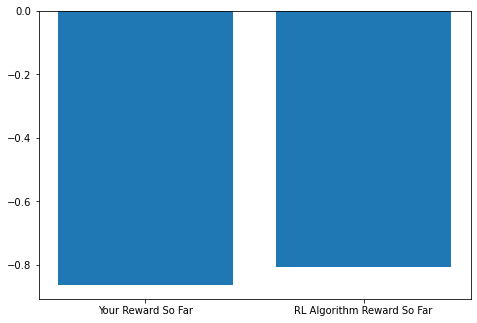

In [1]:
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(500, 800))
#display.start()

import or_suite
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import rendering

import time
import copy

a = 5
b = 2
CONFIG = {'epLen': 5,
    'arrival_dist': lambda x : np.random.beta(a,b), 
    'alpha': 0.25, 
    'starting_state': np.array([0.0, 0.0]), 
    'num_ambulance': 2,
    'norm': 1
}

alpha = CONFIG['alpha']
epLen = CONFIG['epLen']
state = CONFIG['starting_state']
num_ambulance = CONFIG['num_ambulance']

agent = or_suite.agents.ambulance.command_line_metric.commandLineAgent(epLen)
env = gym.make('Ambulance-v0', config=CONFIG)
env.reset()

done = False
your_rewards = []
heuristic_agent_rewards = []
your_total_reward = 0
heuristic_agent_total_reward = 0

median_est = (a - 1/3)/(a + b - 2/3)
heuristic_agent_states = [state]

x_axis = ['Your Reward So Far', 'RL Algorithm Reward So Far']


def display_animation(screen, time_to_display):
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    if time_to_display is not None:
        ipythondisplay.display(plt.gcf())
        time.sleep(time_to_display)

def plot_rewards():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    y_axis = [your_total_reward, heuristic_agent_total_reward]
    ax.bar(x_axis, y_axis)
    plt.show()


while not done:
    action = agent.greedy(state, 0)
    
    state, reward, done, info = env.step(action)
    your_rewards.append(reward)
    your_total_reward += reward

    # by comparing the final state with the action the user chose, we can figure out where the most recent arrival was
    previous_arrival_ind = np.argmax(np.abs(action - state))
    previous_arrival = state[previous_arrival_ind]

    # the heuristic agent always chooses to put all the ambulances at the median estimate
    heuristic_agent_action = np.full(num_ambulance, median_est)

    # the state will have one ambulance where the call arrived, and all other ambulances at the median estimate
    # doesn't matter which ambulance responds to the call because they're all at the same place
    heuristic_agent_state = np.concatenate([np.full(num_ambulance - 1, median_est), [previous_arrival]])
    heuristic_agent_states.append(heuristic_agent_state)

    heuristic_agent_reward = -1 * (alpha * np.sum(np.abs(heuristic_agent_states[-2] - heuristic_agent_action)) + (1 - alpha) * np.sum(np.abs(heuristic_agent_action - heuristic_agent_state)))
    heuristic_agent_rewards.append(heuristic_agent_reward)
    heuristic_agent_total_reward += heuristic_agent_reward
    
    env.viewer = rendering.PygletWindow(850, 550)
    env.viewer.window.set_visible(False)
    screen1, screen2, screen3 = env.render(mode='rgb_array')
    
    # display each step of the environment for 2 seconds
    display_animation(screen1, 2)
    display_animation(screen2, 2)
    display_animation(screen3, None)

    # plot your reward vs the agent's reward
    plot_rewards()
    time.sleep(2)

    print("\nThe most recent call arrival was at " + str(previous_arrival) + ", and ambulance " + str(previous_arrival_ind+1) + " responded to the call.\n")

    time.sleep(2)
    
    if not done:
        cont = input("Continue? [y/n]")
        if cont == "n":
            done = True
            break


ipythondisplay.clear_output(wait=True)
env.close()

if np.sum(your_rewards) > np.sum(heuristic_agent_rewards):
    print("CONGRATS! You beat the RL algorithm.")
else:
    print("You did not get a better reward than the RL algorithm.")

print("\nYour total reward over all iterations was ", round(sum(your_rewards),3))
print("The RL algorithm's total reward over all iterations was ", round(sum(heuristic_agent_rewards),3), "\n")

plot_rewards()

This problem is well-studied in the setting where the number of ambulances $k$ is small and in simple metric spaces.  However,

- When the number of ambulances $k$ increases the complexity of the optimal policy increases dramatically
- In real-world situations, the problem gets complicated in more 'realistic' metrics (and a dataset based in Ithaca is provided)
- People construct a weighted metric for algorithm design, one cares about evaluating and balancing between multiple metrics
- How to evaluate if your RL algorithm is good? Need to benchmark against well-known heuristics for this problem to understand the value that RL approach brings

# Sample Simulation and Research Questions

Here we use the ambulance metric environment as outlined in `or_suite/envs/ambulance/ambulance_metric.py`.  The package has default specifications for all of the environments in the file `or_suite/envs/env_configs.py`, and so we use one the default for the ambulance problem in a metric space.

In addition, we need to specify the number of episodes for learning, and the number of iterations (in order to plot average results with confidence intervals).

## Step 1: Pick simulation parameters

Next we need to specify parameters for the simulation. This includes setting a seed, the frequency to record the metrics, directory path for saving the data files, a deBug mode which prints the trajectory, etc.

In [3]:
CONFIG =  or_suite.envs.env_configs.ambulance_metric_default_config

epLen = CONFIG['epLen']
nEps = 10
numIters = 2

epsilon = (nEps * epLen)**(-1 / 4)
action_net = np.arange(start=0, stop=1, step=epsilon)
state_net = np.arange(start=0, stop=1, step=epsilon)

scaling_list = [0.1]

def beta(step):
    return np.random.beta(5,2)

DEFAULT_SETTINGS = {'seed': 1, 
                    'recFreq': 1, 
                    'dirPath': '../data/ambulance/', 
                    'deBug': False, 
                    'nEps': nEps, 
                    'numIters': numIters, 
                    'saveTrajectory': True, 
                    'epLen' : 5,
                    'render': False,
                    'pickle': False
                    }

alpha = CONFIG['alpha']
arrival_dist = beta
num_ambulance = CONFIG['num_ambulance']

ambulance_env = gym.make('Ambulance-v0', config=CONFIG)
mon_env = Monitor(ambulance_env)

NameError: name 'Monitor' is not defined

##  Step 2: Pick list of algorithms

We have several heuristics implemented for each of the environments defined, in addition to a `Random` policy, and some `RL discretization based` algorithms. 

The `Stable` agent only moves ambulances when responding to an incoming call and not in between calls. This means the policy $\pi$ chosen by the agent for any given state $X$ will be $\pi_h(X) = X$

The `Median` agent takes a list of all past call arrivals sorted by arrival location, and partitions it into $k$ quantiles where $k$ is the number of ambulances. The algorithm then selects the middle data point in each quantile as the locations to station the ambulances.

In [14]:
agents = { 'SB PPO': PPO(MlpPolicy, mon_env, gamma=1, verbose=0, n_steps=epLen),
'Random': or_suite.agents.rl.random.randomAgent(),
'Stable': or_suite.agents.ambulance.stable.stableAgent(CONFIG['epLen']),
'Median': or_suite.agents.ambulance.median.medianAgent(CONFIG['epLen'])
        }

NameError: name 'mon_env' is not defined

##  Step 3: Run Simulations

Run the different heuristics in the environment

In [15]:
path_list_line = []
algo_list_line = []
path_list_radar = []
algo_list_radar= []
for agent in agents:
    print(agent)
    DEFAULT_SETTINGS['dirPath'] = '../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__)+'/'
    if agent == 'SB PPO':
        or_suite.utils.run_single_sb_algo(mon_env, agents[agent], DEFAULT_SETTINGS)
    elif agent == 'AdaQL' or agent == 'Unif QL' or agent == 'AdaMB' or agent == 'Unif MB':
        or_suite.utils.run_single_algo_tune(ambulance_env, agents[agent], scaling_list, DEFAULT_SETTINGS)
    else:
        or_suite.utils.run_single_algo(ambulance_env, agents[agent], DEFAULT_SETTINGS)

    path_list_line.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__))
    algo_list_line.append(str(agent))
    if agent != 'SB PPO':
        path_list_radar.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__))
        algo_list_radar.append(str(agent))

NameError: name 'agents' is not defined

## Step 4: Generate Figures

Create a chart to compare the different heuristic functions.  Also able to produce heat maps with additional custom metrics, here taken to be the mean response time and variance of mean response time.

In [16]:
fig_path = '../figures/'
fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__)+'_line_plot'+'.pdf'
or_suite.plots.plot_line_plots(path_list_line, algo_list_line, fig_path, fig_name, int(nEps / 40)+1)

additional_metric = {'MRT': lambda traj : or_suite.utils.mean_response_time(traj, lambda x, y : np.abs(x-y)), 
                     'RTV': lambda traj : or_suite.utils.response_time_variance(traj, lambda x, y : np.abs(x-y))}




fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__)+'_radar_plot'+'.pdf'
or_suite.plots.plot_radar_plots(path_list_radar, algo_list_radar,
fig_path, fig_name,
additional_metric
)


NameError: name 'arrival_dist' is not defined

![title](ambulance_metric_1_0.25_beta_line_plot-1.png)

![title](ambulance_metric_1_0.25_beta_radar_plot-1.png)